# **Heterogeneous Model Verification**
# 1.**Load modules**

In [1]:
from codes.HeterFuctions import *

# 2.**Preparation**

## 2.1.**Load Mirror-Traffic Highway-departure Data**

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~Load mirror data
path = '../Datasets/Mirror/Highway-departure/trajectory.csv'
mirror = data_columns_selection(pd.read_csv(path))    ### raw dataset

## 2.2.**Potential fields**

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~Basic parameters
P1, P2, σ, Δ = 8, 2, 0.5, 0.05
X0, Y0 = np.arange(0, 1000, Δ), np.arange(0, 20, Δ)
X, Y = np.meshgrid(X0, Y0)
α, β = 8, 1

#~~~~~~~~~~~~~~~~~~~~~~~Road boundary potential
U_raod_1 = Potential.StraightBoundary(X, Y, [[0,250],[0.5,0.5]], P1, σ, -1)
U_raod_2 = Potential.StraightBoundary(X, Y, [[0,250],[7.6,7.6]], P1, σ, 1)

#~~~~~~~~~~~~~~~~~~~~~~~Lane markings potential
U_m_1 = Potential.LaneMarkings(X, Y, [[0,250], [3.7, 3.7]], P2, σ, -1)
U_m_2 = Potential.LaneMarkings(X, Y, [[0,150], [7.6, 7.6]], P2, σ, 1)
U_m_3 = Potential.LaneMarkings(X, Y, [[50, 230], [7.6, 13.5]], P2, σ, 0)


#~~~~~~~~~~~~~~~~~~~~~~~Ramp boundary potential
U_ramp_1 = Potential.RampBoundary(X, Y, [[0,230],[8.5,16.5]], P1, σ, -1)
U_ramp_2 = Potential.RampBoundary(X, Y, [[150,250],[7.6,11]], P1, σ, 1)

#~~~~~~~~~~~~~~~~~~~~~~~Virtual boundary potential
points = [[21.58, 0.5], [150, 7.6]]
shape_k = [0.75, 0.2, 0.55, 0.4]
xvals, yvals = bezier_curve(points, shape_k, nTimes=3000)
U_vbp = Potential.VirtualBoundary(X, Y, xvals, yvals, X0, Y0, σ, α, β)

#~~~~~~~~~~~~~~~~~~~~~~~Summary these potential fields
# U = U_vbp+ U_raod_1 + U_raod_2 + U_m_1 + U_m_2 + U_m_3 + U_ramp_1 + U_ramp_2
U = U_raod_1 + U_raod_2 + U_m_1 + U_m_2 + U_m_3 + U_ramp_1 + U_ramp_2

## --- Plot the complex potential fields
# fig,ax = plt.subplots(figsize=(10,5))
# con = ax.contourf(X, Y, U, 100, cmap='jet')
# cb = fig.colorbar(con, ax=ax)
# cb.ax.tick_params(labelsize=14)
# plt.xlabel('Longitudinal position(m)', fontsize=16)
# plt.ylabel('Lateral position(m)', fontsize=16)
# plt.title('Virtual Boundary Potential Field', fontsize=16)
# plt.tick_params(labelsize=14)
# plt.xlim(0,250)
# plt.ylim(-1,21)
# plt.gca().invert_yaxis()



## --- determine the feasible the region
'''

'''
# region = GetFeasibleRegion.GetWholeRegionRamp(X)        # mothod 1*
# region = GetFeasibleRegion.GetWholeRegionStraight(Y)    # method 2
# scio.savemat('region.mat', {'data':region})
x_last, y_last, vx_last, vy_last, Δx, dx = 150, 1.5, 20, 1.5, 50, 1.75
Δx_min = 30
x_index, y_index, sub_region = GetFeasibleRegion.GetPartRegion(scio.loadmat('region.mat')['data'], x_last, y_last, Δx, Δx_min, X, Y)

## 2.1.**Load Mirror-Traffic Highway-departure Data**

## 2.2.**Data preparation**

In [10]:
## --- filter the id
vId = mirror.id.unique()
group = mirror.groupby('id')
ids = [id for id in vId if 3 in group.get_group(id).laneId.unique().tolist()]
idx = 100

## --- get the time
t0, t1 = mirror[mirror.id==1997].frame.iloc[0], mirror[mirror.id==1997].frame.iloc[-1]
# for vid in mirror[(mirror.frame>t0) & (mirror.frame<t1) & (mirror.id != 1997)].id.unique():
#     print(vid, mirror[mirror.id==vid][(mirror.frame>t0) & (mirror.frame<t1) ].shape)

## 2.5.**Simulation**👽

### 2.5.1.**Agent Car Simulation**

9.311890705390656


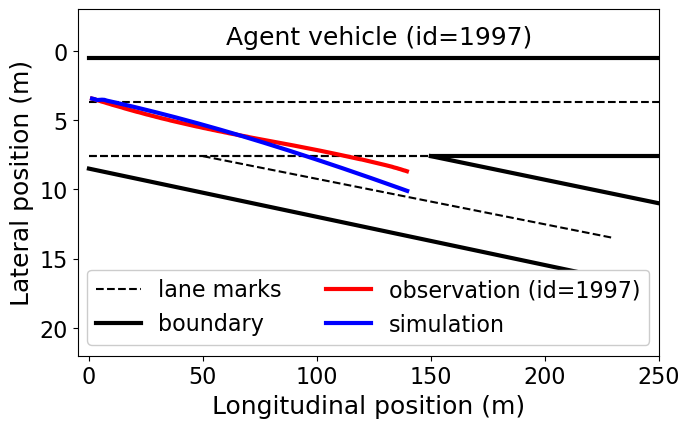

In [12]:
## --- Select a trajectory randomly
id = 1997  # agent vehicle: 1997
# id = 1999  # rear-right vehicle

trajectory = mirror[mirror.id==id]

## --- Set basic parameters
a, b, s0, T, lf, lr, vd = 2.95, 2.21, 2.58, 1.3, 2.5, 2.5, np.sqrt(trajectory.xVelocity**2+trajectory.yVelocity**2).mean() + 2
a_sigma_d, v_sigma_d, lambda1, lambda2 = 5.81, 5, 25, 50

## --- Simulation time
T_frame = trajectory.frame.values
dt, Δx, Δx_min, L = 0.04, 60, 30, 150


# Initial status of the simulation vehicle
vehicle_simulation = {T_frame[0]: [sqrt((trajectory.loc[trajectory.index[0]].xVelocity)**2 + (trajectory.loc[trajectory.index[0]].yVelocity)**2), 
                                   trajectory.loc[trajectory.index[0]].x, trajectory.loc[trajectory.index[0]].y,
                                   trajectory.loc[trajectory.index[0]].xVelocity, trajectory.loc[trajectory.index[0]].yVelocity,
                                   trajectory.loc[trajectory.index[0]].xAcceleration, trajectory.loc[trajectory.index[0]].yAcceleration,
                                   0*np.pi/180, 0, 0 ]}    ### {t:[Vt, x, y, vx, vy, ax, ay, sigma, phi, v_sigma]}

Xe, Ye, dS = [], [], []     ### the expected position sets
# for i in tqdm(range(1,len(T_frame))):
for i in range(1,len(T_frame)):
    # Obtain vehicle's status at last step
    [V_last, x_last, y_last, vx_last, vy_last, ax_last, ay_last, sigma_last, phi_last, v_sigma_last] = vehicle_simulation[T_frame[i-1]]
    
    # Obtain the surrounding vehicle's status
    surrounding_vehicles = mirror[(mirror['frame']==T_frame[i]) & (mirror['x']>x_last) & (mirror['x']<=x_last+L)]
    index = surrounding_vehicles.index.tolist()
    U_veh = np.zeros(X.shape)
    d_V = [0]
    for j in index:
        veh = surrounding_vehicles.loc[j]
        V_relative = np.sqrt((vx_last - veh.xVelocity)**2 + (vy_last-veh.yVelocity)**2 )
        U_veh = U_veh + Potential_Vehicle(X,Y,veh.x,veh.y,veh.length,veh.width, V_relative, 16, 50, 1)
        d_V.append(V_relative)  
        
    U_all = U + U_veh    
    
    # Find the expected position
    Δx_min = 30
    x_e, y_e = get_vehicle_expected_position(x_last, y_last, Δx, Δx_min, X, Y, U_all)
    Xe.append(x_e)
    Ye.append(y_e)
    
    # Calculate the 'θ'
    alpha = Get_alpha(x_e, y_e, x_last, y_last)

    # Calculate the 's' and 'Δv'
    d_v = np.mean(d_V)
    s = sqrt((x_e-x_last)**2 + (y_e-y_last)**2)
    dS.append(s)
    
    # Update vehicular dynamics parameters: 'σ', 'v_σ', 'β', 'φ'
    sigma_new, v_sigma_new = Get_sigma(v_sigma_last, a_sigma_d, v_sigma_d, dt, sigma_last, alpha, lambda1, lambda2)
    beta = Get_beta(sigma_new, lr, lf)    ### calculate the 'β'
    Va, V_new = IDM(T, vd, s, a, b, s0, dt, d_v, V_last, v_sigma_new, v_sigma_d)
    phi_new = Get_phi(V_new, sigma_new, beta, lr, lf, dt, phi_last)
    
    # Update vehicle's status
    vx_new, vy_new, ax_new, ay_new, x_new, y_new = VehicleStatus(Va, V_new, x_last, y_last, vx_last, vy_last, phi_new, beta, dt)
    vehicle_simulation[T_frame[i]] = [V_new, x_new, y_new, vx_new, vy_new, ax_new, ay_new, sigma_new, phi_new, v_sigma_new]




#####################################################
## --- Plot the simulation results
fig, ax = plt.figure(figsize=(7.5,4.5)), plt.axes()
plot_topology()
plt.plot(trajectory.x, trajectory.y, lw=3, c='r', label='observation (id='+str(int(id))+')')
results = np.array(list(vehicle_simulation.values()))
x = results[:, 1]
y = results[:, 2]
plt.plot(x,y,'-',linewidth=3, c='b', label='simulation')
plt.xlabel('Longitudinal position (m)', fontsize=18)
plt.ylabel('Lateral position (m)', fontsize=18)
plt.xlim(-5,250)
plt.ylim(-3,22)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16, framealpha=1, ncol=2, loc='lower center')
plt.gca().invert_yaxis()
plt.text(60, -0.5, 'Agent vehicle (id='+str(int(id))+')', fontsize=18)
# plt.text(20, -0.5, 'Rear-right following vehicle (id='+str(int(id))+')', fontsize=18)


print(dtw_ndim.distance(np.array([x, y]).T, trajectory[['x', 'y']].values))


##----------------------------------------------------------------------------------Save simulation results
vehicle_1997 = pd.DataFrame(np.array(list(vehicle_simulation.values())), columns=
                          ['Vt', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'sigma', 'phi', 'v_sigma'])
vehicle_1997['frame'] = T_frame
vehicle_1997['x_real'] = trajectory.x.values
vehicle_1997['y_real'] = trajectory.y.values
# vehicle_1997.to_csv('results/simulation_results_vehicle_1997.csv', index=False)

### 2.5.2.**Replace Real Trajectory with Simulated Trajectory**

In [14]:
## --- process the simulation results of the agent car
results = np.array(list(vehicle_simulation.values()))

## --- Simulation without MPC
trajectroy_simulation = trajectory
trajectroy_simulation['x'] = results[:,1]
trajectroy_simulation['y'] = results[:,2]
trajectroy_simulation['xVelocity'] = results[:,3]
trajectroy_simulation['yVelocity'] = results[:,4]
trajectroy_simulation['xAcceleration'] = results[:,5]
trajectroy_simulation['yAcceleration'] = results[:,6]
mirror[mirror['id']==id] = trajectroy_simulation

### 2.5.3.**Following Car Simulation**

Text(20, -0.5, 'Rear-right following vehicle (id=1999)')

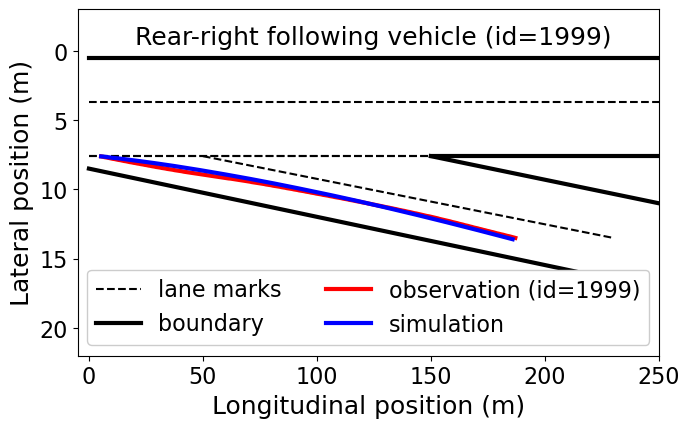

In [16]:
## --- Select a trajectory randomly
# id = 1997  # agent vehicle: 1997
id = 1999  # rear-right vehicle
trajectory = mirror[mirror.id==id]

## --- Set basic parameters
a, b, s0, T, lf, lr, vd = 2.95, 2.21, 2.58, 1.3, 2.5, 2.5, np.sqrt(trajectory.xVelocity**2+trajectory.yVelocity**2).mean() + 2
a_sigma_d, v_sigma_d, lambda1, lambda2 = 5.81, 5, 25, 50

## --- Simulation time
T_frame = trajectory.frame.values
dt, Δx, Δx_min, L = 0.04, 57, 30, 150

## --- Initial status of the simulation vehicle
vehicle_simulation = {T_frame[0]: [sqrt((trajectory.loc[trajectory.index[0]].xVelocity)**2 + (trajectory.loc[trajectory.index[0]].yVelocity)**2), 
                                   trajectory.loc[trajectory.index[0]].x, trajectory.loc[trajectory.index[0]].y,
                                   trajectory.loc[trajectory.index[0]].xVelocity, trajectory.loc[trajectory.index[0]].yVelocity,
                                   trajectory.loc[trajectory.index[0]].xAcceleration, trajectory.loc[trajectory.index[0]].yAcceleration,
                                   0*np.pi/180, 0, 0 ]}    ### {t:[Vt, x, y, vx, vy, ax, ay, sigma, phi, v_sigma]}

Xe, Ye, dS = [], [], []     # the expected position sets
# for i in tqdm(range(1,len(T_frame))):
for i in range(1,len(T_frame)):
    # Obtain vehicle's status at last step
    [V_last, x_last, y_last, vx_last, vy_last, ax_last, ay_last, sigma_last, phi_last, v_sigma_last] = vehicle_simulation[T_frame[i-1]]
    
    # Obtain the surrounding vehicle's status
    surrounding_vehicles = mirror[(mirror['frame']==T_frame[i]) & (mirror['x']>x_last) & (mirror['x']<=x_last+L)]
    index = surrounding_vehicles.index.tolist()
    U_veh = np.zeros(X.shape)
    d_V = [0]
    for j in index:
        veh = surrounding_vehicles.loc[j]
        V_relative = np.sqrt((vx_last - veh.xVelocity)**2 + (vy_last-veh.yVelocity)**2 )
        U_veh = U_veh + Potential_Vehicle(X,Y,veh.x,veh.y,veh.length,veh.width, V_relative, 16, 50, 1)
        d_V.append(V_relative)  
        
    U_all = U + U_veh    
    
    # Find the expected position
    Δx_min = 30
    x_e, y_e = get_vehicle_expected_position(x_last, y_last, Δx, Δx_min, X, Y, U_all)
    Xe.append(x_e)
    Ye.append(y_e)
    
    # Calculate the 'θ'
    alpha = Get_alpha(x_e, y_e, x_last, y_last)

    # Calculate the 's' and 'Δv'
    d_v = np.mean(d_V)
    s = sqrt((x_e-x_last)**2 + (y_e-y_last)**2)
    dS.append(s)
    
    # Update vehicular dynamics parameters: 'σ', 'v_σ', 'β', 'φ'
    sigma_new, v_sigma_new = Get_sigma(v_sigma_last, a_sigma_d, v_sigma_d, dt, sigma_last, alpha, lambda1, lambda2)
    beta = Get_beta(sigma_new, lr, lf)    ### calculate the 'β'
    Va, V_new = IDM(T, vd, s, a, b, s0, dt, d_v, V_last, v_sigma_new, v_sigma_d)
    phi_new = Get_phi(V_new, sigma_new, beta, lr, lf, dt, phi_last)
    
    # Update vehicle's status
    vx_new, vy_new, ax_new, ay_new, x_new, y_new = VehicleStatus(Va, V_new, x_last, y_last, vx_last, vy_last, phi_new, beta, dt)
    vehicle_simulation[T_frame[i]] = [V_new, x_new, y_new, vx_new, vy_new, ax_new, ay_new, sigma_new, phi_new, v_sigma_new]



###################################################
## --- Plot the simulation results
fig, ax = plt.figure(figsize=(7.5,4.5)), plt.axes()
plot_topology()
plt.plot(trajectory.x, trajectory.y, lw=3, c='r', label='observation (id='+str(int(id))+')')
results = np.array(list(vehicle_simulation.values()))
x = results[:, 1]
y = results[:, 2]
plt.plot(x,y,'-',linewidth=3, c='b', label='simulation')
plt.xlabel('Longitudinal position (m)', fontsize=18)
plt.ylabel('Lateral position (m)', fontsize=18)
plt.xlim(-5,250)
plt.ylim(-3,22)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16, framealpha=1, ncol=2, loc='lower center')
plt.gca().invert_yaxis()
plt.text(20, -0.5, 'Rear-right following vehicle (id='+str(int(id))+')', fontsize=18)